In [1]:
import sympy as sp
from matplotlib import pyplot as plt
import numpy as np

from sympy import init_printing
init_printing()

# Classical mechanics with SymPy
SymPy is great for automating a log of the machinery of classical Lagrangian and Hamiltonian mechanics. (Great enough for someone to build an entire [celestial mechanics package](https://celmech.readthedocs.io/en/latest/) on top of SymPy's capabilities for automating mechanics...)

In this example, we'll use sympy to generate equations of motion for a simple pendulum, turn these equations into callable functions, then numerically integrate the system.

## Simple Pendulum

We'll start by constructing the Lagrangian for a pendulum with mass $m$, length $l$, subject to a gravitational accelration $-g$. We'll use the angular displacement of the pendulum, $\theta$ as our generalized coordinate. 

### Lagrangian formulation

First we'll create our variables:

In [2]:
theta_dot = sp.symbols(r"\dot{\theta}",real= True)
p,theta,t,l,g,m = sp.symbols("p,theta,t,l,g,m",real=True)

Now we'll create expressions for the kinetic energy, $T$, and potential energy, $V$, which we then combine to get the Lagrangian, $L(\theta,\dot{\theta}) = T(\dot{\theta})-V(\theta)$ 

In [3]:
KE = m * l*l*theta_dot*theta_dot/sp.S(2)
PE = m * g * l * (1 - sp.cos(theta))
lagrangian = KE - PE

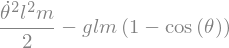

In [4]:
lagrangian

### Hamiltonian formulation
Recall that the Hamiltonian formulation is obtained form the Lagrangian formulation via a so-called Legendre transform, where we 

- (i) define a new momentum variable, $p = \frac{\partial }{\partial \dot{\theta}} L(\theta,\dot{\theta}) $
- (ii) Solve for $\dot\theta(p)$ by inverting the above equation 
- (iii)  Obtain the Hamiltonian as $H(\theta,p) = p\cdot\dot\theta(p) - L(\theta,\dot\theta(p))$

In [5]:
to_solve = sp.Eq(p , sp.diff(lagrangian,theta_dot))
to_solve

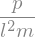

In [6]:
# get our solution
theta_dot_soln = sp.solve(to_solve,theta_dot)[0]
theta_dot_soln

Construct the Hamiltonian

In [7]:
hamiltonian = (theta_dot * p - lagrangian).subs({theta_dot:theta_dot_soln})

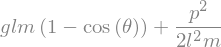

In [8]:
hamiltonian

### Hamiltonian equations of motion

Hamilton's equations are 
$$
\begin{eqnarray}
\frac{d}{dt}\theta &=& \partial_{p} H(\theta,p)
\\
\frac{d}{dt}p &=&  - \partial_{\theta} H(\theta,p)
\end{eqnarray}
$$

Get the right-hand side of these equations as a vector 

In [9]:
flow = sp.Matrix([sp.diff(hamiltonian,p),-1* sp.diff(hamiltonian,theta)])

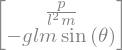

In [10]:
flow

### Integration
We now have an ordinary differential equation for $(\theta,p)$ in symbolic form.

We could try to go about deducing an analytic solution, but who has time for learning elliptic integrals? Instead, we're going to turn our symbolic expressions into callable functions that we'll then feed to an ODE solver to generate a numerical solution.

We'll use scipy's `solve_ivp` function to integrate; let's see what we need to pass it:

In [11]:
from scipy.integrate import solve_ivp

In [12]:
help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co

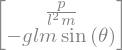

In [13]:
flow

Looking at the `solve_ivp` documentation, we need a function that takes the time and a state vector, $y$, possibly along with some other arguments, `args`, and returns $dy/dt$. 

SymPy's `lambidfy` can give us something like this:

In [14]:
flow_func = sp.lambdify((t,theta,p,g,l,m),flow)

In [15]:
Ng = 9.8 # numerical value for  grav. accelration
Nl = 1  # pendulum length, in meters
Nm = 0.5 # pendulum mass, in kg

theta0 = np.pi/2 # initial theta
p0 = 0 # initial p value

This has given us a function that we can call:

In [16]:
flow_func(0,theta0,p0,Ng,Nl,Nm)

array([[ 0. ],
       [-4.9]])

... that agree with substituting numerical values in our original expression:

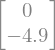

In [17]:
flow.subs({g:Ng,l:Nl,m:Nm,p:0,theta:np.pi/2})

Our `flow_func` isn't exactly in the form called for by `solve_ivp`, but we can easily make a wrapper that conforms to what `solve_ivp` asks for:

In [18]:
fn = lambda t,y: flow_func(t,*y,Ng,Nl,Nm).reshape(-1)

In [19]:
y0 = (theta0,p0)

fn(0,y0)

array([ 0. , -4.9])

### Integrate

In [20]:
Tfin = 10
Nout = 128
times = np.linspace(0,Tfin,Nout)

soln = solve_ivp(
    fn,
    (0,Tfin),
    y0,
    t_eval=times
)
soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.874e-02 ...  9.921e+00  1.000e+01]
        y: [[ 1.571e+00  1.540e+00 ...  5.338e-01  2.001e-01]
            [ 0.000e+00 -3.857e-01 ... -2.039e+00 -2.180e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 254
     njev: 0
      nlu: 0

### Plot our results

Text(0.5, 0, 'Time')

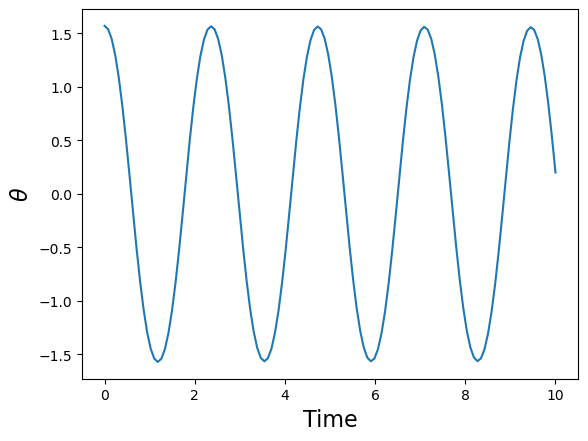

In [21]:
plt.plot(soln.t,soln.y[0])
plt.ylabel(r"$\theta$",fontsize=16)
plt.xlabel(r"Time",fontsize=16)

## Exercise 1

Lambidfy the Hamiltonian function, `hamiltonian`, defined about and use it to plot the pendulum's energy versus time.

In [22]:
ham_func = sp.lambdify((theta,p,g,l,m),hamiltonian)

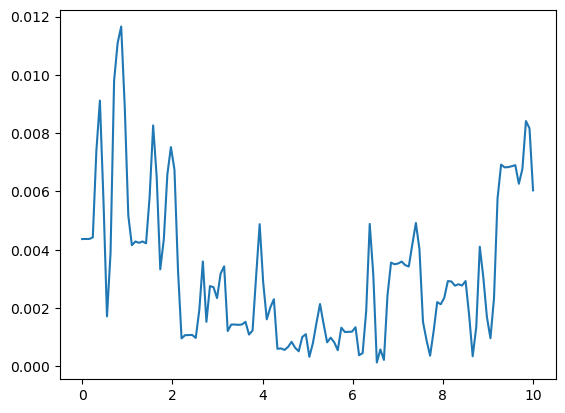

In [23]:
E = ham_func(soln.y[0],soln.y[1],Ng,Nl,Nm)
dE = np.abs(E/np.mean(E)-1)
plt.plot(soln.t,dE)

## Getting the Jacobian for numerical integration

From the `solve_ivp` help documentation, we see that we can optionally pass the Jacobian of our flow as the `jac` parameter, which is used by some integration methods. In particular, implicit methods, are often improved by inclusion of Jacobian information.  

Furthermore, implicit methods usually have much better energy conservation properties for Hamiltonian systems. This is not so important for our simple pendulum example, but can often be important for more complicated systems you may encounter in astrodynamics.

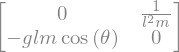

In [24]:
qp_vars = (theta,p)
flow_jacobian = sp.Matrix(2,2,lambda i,j: sp.diff(flow[i],qp_vars[j]))
flow_jacobian

Let's lambidfy again:

In [25]:
jacobian_func  = sp.lambdify((t,theta,p,g,l,m),flow_jacobian)

In [26]:
fn = lambda t,y: flow_func(t,*y,Ng,Nl,Nm).reshape(-1)
Dfn = lambda t,y: jacobian_func(t,*y,Ng,Nl,Nm)

In [27]:
Dfn(0,y0)

array([[ 0.00000000e+00,  2.00000000e+00],
       [-3.00038466e-16,  0.00000000e+00]])

In [28]:
Tfin = 10
Nout = 128
times = np.linspace(0,Tfin,Nout)

soln = solve_ivp(
    fn,
    (0,Tfin),
    y0,
    t_eval=times,
    jac = Dfn,
    method='Radau'
)
soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.874e-02 ...  9.921e+00  1.000e+01]
        y: [[ 1.571e+00  1.540e+00 ...  6.278e-01  2.993e-01]
            [ 0.000e+00 -3.857e-01 ... -1.991e+00 -2.164e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 494
     njev: 18
      nlu: 58

## Exercise 1.5
Using your lambdified Hamiltonian, confirm that the implicit Radau method that we just used has better energy conservation than our original solution


## Exercise 2

Derive equations of motion directly from the Lagrangian, (i.e., the [Euler-Lagrange equations](https://en.wikipedia.org/wiki/Euler–Lagrange_equation)), and integrate them as we did with Hamilton's equations. 

## Exercise 3

Can you derive and integrate Hamilton's equations of motion for the [double pendulum](https://en.wikipedia.org/wiki/Double_pendulum)? In case you need inspirartion for initial conditions, see [here](https://twitter.com/pendulum_bot?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor).
